In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jens/Documents/NMRAuswertung")
print(sys.path)
from nmr_lib import *


%matplotlib inline

['', '/home/jens/Documents/NMRAuswertung', '/home/jens/.local/anaconda/bin', '/home/jens/bin', '/home/jens/.local/bin', '/usr/local/sbin', '/usr/local/bin', '/usr/sbin', '/usr/bin', '/sbin', '/bin', '/usr/games', '/usr/local/games', '/snap/bin', '/home/jens/.local/anaconda/lib/python36.zip', '/home/jens/.local/anaconda/lib/python3.6', '/home/jens/.local/anaconda/lib/python3.6/lib-dynload', '/home/jens/.local/anaconda/lib/python3.6/site-packages', '/home/jens/.local/anaconda/lib/python3.6/site-packages/IPython/extensions', '/home/jens/.ipython', '/home/jens/Documents/NMRAuswertung']


In [2]:
dirnamet1 = [
    "12", "14", "17", "20", "23", "25", "28", "30", "33", "35", "38", "40",
    "43", "46", "49", "56"
]
tempt1 = [
    380.0, 390.0, 375.0, 385.0, 370.0, 365.0, 360.0, 355.0, 350.0, 345.0,
    340.0, 330.0, 335.0, 320.0, 310.0, 340.0
]

trigger_time_t1 = 4e-6
t1phase = 12 * np.pi / 180

#td_1 und td_2 werden mittlerweile automatisch ausgelesen
dw = 1e-6  # Dwelltime, in Topspin als DW bezeichnet, Zeit zwischen zwei Punkten
grpdly = 68  # wie viel ist vor dem eigentlich zu messenden Signal
# (meist durch Variable grpdly gegeben, welche bei allen euren
# Messungen 68 war)

maxtplot = 150e-6

dw = dw * 2  # Bruker verdoppelt immer nocheinmal die dwell time

In [3]:
folder = "12"
trigger_time = trigger_time_t1
phase = t1phase


def extract_bruker_generic(folder, trigger_time, phase):
    effgrpdly = int(grpdly + trigger_time / dw)
    if effgrpdly < 0:
        effgrpdly = 0
    times_2 = np.loadtxt("../T1/%s/vdlist" % (folder))
    f = open("../T1/%s/ser" % (folder), "rb")
    data = np.frombuffer(f.read(), dtype="<i4")
    td_2 = len(times_2)
    td_1 = int(len(data) / td_2)
    dshape = (td_2, int(td_1 / 2), 2)
    data.shape = dshape
    cropped = np.zeros(dshape)
    cropped[:, 0:int(td_1 / 2) - effgrpdly, :] = data[:, effgrpdly:, :]
    signal = cropped[:, :, 0] + 1j * cropped[:, :, 1]
    times_1 = dw * np.arange(0, int(td_1 / 2))

    phase_sug = np.angle(
        signal[0:5, 0:5].mean()
    )  #die gewünschte Phase kann ganz gut abgeschätzt werden indem der Winkel in der komplexen Ebene für den ersten Wert berechnet wird.
    print(
        "Schaetzung der Phase von Ordner %s: %.0f (%.2f rad) verwendet: %.0f" %
        (folder, phase_sug * 180 / np.pi, phase_sug, phase * 180 / np.pi))
    #Phasenkorrektur anwenden:
    signal = signal * np.exp(-1j * phase)

    fig = plt.figure(figsize=(32 / 2.54, 18 / 2.54))
    ax = fig.add_subplot(1, 1, 1)

    for i in range(0, len(signal)):
        ax.plot(times_1[0:int(maxtplot / dw)],
                np.real(signal[i, 0:int(maxtplot / dw)]))
        ax.plot(times_1[0:int(maxtplot / dw)],
                np.imag(signal[i, 0:int(maxtplot / dw)]))

    fig.savefig("auswertung/%s_signal.pdf" % (folder))
    plt.close(fig)

    #echos ausrechnen:
    echos = signal[:, 0:10].mean(axis=1)
    echo_err = np.real(signal[:, -513:-1]).std(axis=1) + 1j * np.real(
        signal[:, -513:-1]).std(axis=1)

    mask = echo_err != 0.0

    times_2 = times_2[mask]
    echos = echos[mask]
    echo_err = echo_err[mask]

    return times_1, signal, times_2, echos, echo_err

In [4]:
times_1, signal, times_2, echos, echo_err = extract_bruker_generic(
        folder, trigger_time, phase)

Schaetzung der Phase von Ordner 12: 12 (0.21 rad) verwendet: 12


In [5]:
times_1

array([  0.00000000e+00,   2.00000000e-06,   4.00000000e-06, ...,
         8.18600000e-03,   8.18800000e-03,   8.19000000e-03])

In [6]:
times_2

array([  1.00000000e-05,   1.60000000e-05,   2.60000000e-05,
         4.30000000e-05,   7.00000000e-05,   1.13000000e-04,
         1.83000000e-04,   2.98000000e-04,   4.83000000e-04,
         7.85000000e-04,   1.30000000e-05,   2.10000000e-05,
         3.40000000e-05,   5.50000000e-05,   8.90000000e-05,
         1.44000000e-04,   2.34000000e-04,   3.79000000e-04,
         6.16000000e-04,   1.00000000e-03])

In [7]:
echos.real

array([ -6244.87359077,   -187.33708553,   7167.83505535,  17887.63970044,
        27530.59503486,  36667.43267893,  41362.97314017,  44320.811982  ,
        44674.90028465,  44938.36232713,  -3247.54998427,   3911.82278882,
        12551.86690154,  22520.11312107,  32280.71375303,  38720.46364553,
        43097.24615226,  44131.3268552 ,  44543.30374749,  44515.4613518 ])

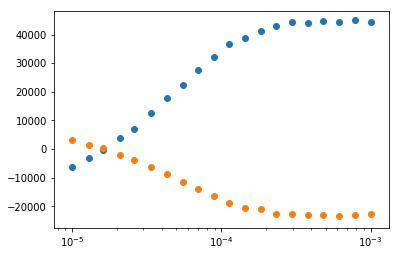

In [8]:
plt.xscale("log")
plt.scatter(times_2, echos.real)
plt.scatter(times_2, echos.imag)

In [9]:
phase, cmplx = phase_fit(echos, 12)

In [10]:
phase

-27.211292572070725

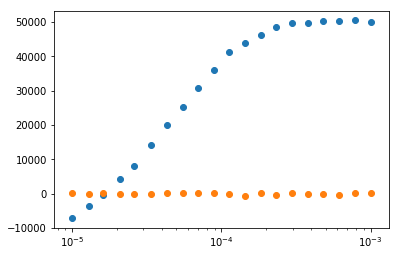

In [11]:
plt.xscale("log")
plt.scatter(times_2, cmplx.real)
plt.scatter(times_2, cmplx.imag)